In [1]:
from IPython import get_ipython

# Clear working space
get_ipython().magic('reset -sf') 

import os
import pandas  as pd
import seaborn as sns
import numpy   as np
import matplotlib.pyplot       as plt
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from scipy.optimize import minimize
from matplotlib import cm

In [55]:
#Set seed for random number generation
np.random.seed(666)

#Get 2000 draws from normal distribution, mean of 650, sd of 200
FICO = np.random.normal(650,200,2000)

#Round up to nearest integer for input array 
FICO = np.ceil(FICO[FICO<851])

1699

In [45]:
beta1 = -0.005
beta0 = .5
pr = np.exp(beta0+beta1*FICO)
pr = pr/(1+pr)
data = pd.DataFrame({'Default':(np.random.uniform(0,1,len(FICO))<pr)*1,
                     'FICO': FICO})

In [46]:
#top 10 observations in data
data[0:10]

,Default,FICO
0,0,815.0
1,0,746.0
2,0,832.0
3,0,536.0
4,0,629.0
5,0,654.0
6,0,462.0
7,0,779.0
8,1,493.0
9,0,772.0


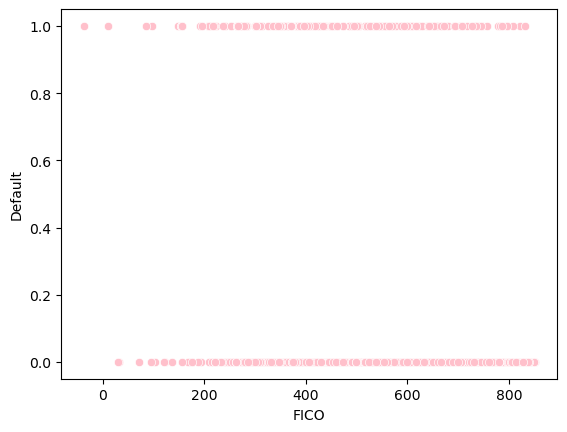

In [49]:
#plot our data
plt.figure()
ax = sns.scatterplot(data = data, x = 'FICO', y='Default', color = 'pink')
plt.show()

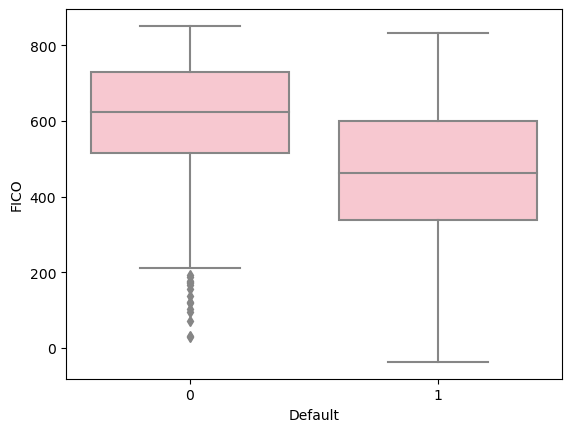

In [50]:
plt.figure()
ax = sns.boxplot(x='Default', y='FICO', data = data, color = 'pink')
plt.show()

In [53]:
#for the intercept 
data['c'] = 1

out = Logit(data['Default'], data[['c', 'FICO']]).fit()
out.summary()

Optimization terminated successfully.
         Current function value: 0.305533
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                 1699
Model:                          Logit   Df Residuals:                     1697
Method:                           MLE   Df Model:                            1
Date:                Sat, 22 Jan 2022   Pseudo R-squ.:                  0.1058
Time:                        02:16:55   Log-Likelihood:                -519.10
converged:                       True   LL-Null:                       -580.55
Covariance Type:            nonrobust   LLR p-value:                 1.465e-28
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c              0.7103      0.255      2.781      0.005       0.210       1.211
FICO          -0.0052      0.000    -10.651      0.000      -0.006      -0.004
==============================================================================
"""

In [54]:
#Print with number of iterations and information criterions
out.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.106     
Dependent Variable: Default          AIC:              1042.2001 
Date:               2022-01-22 02:17 BIC:              1053.0757 
No. Observations:   1699             Log-Likelihood:   -519.10   
Df Model:           1                LL-Null:          -580.55   
Df Residuals:       1697             LLR p-value:      1.4654e-28
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
c         0.7103     0.2554     2.7812   0.0054    0.2097    1.2108
FICO     -0.0052     0.0005   -10.6507   0.0000   -0.0062   -0.0043
=================================================================

"""

In [56]:
#Deviance
sum(-out.resid_dev)

298.8186681785598

/Users/johnkriston/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


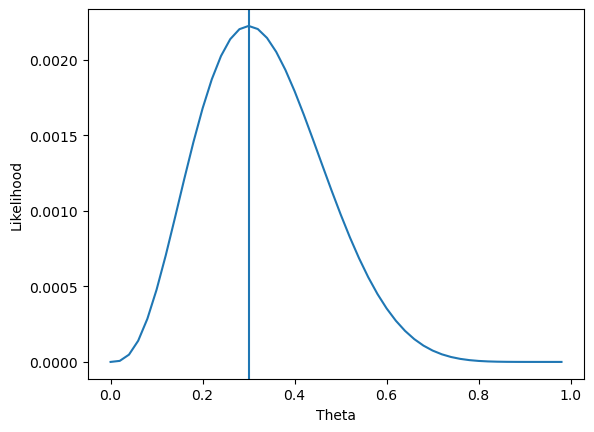

In [58]:
#Coin Toss Experiment
N = 10
nhead = 3

def like(theta, nhead, N):
    return(theta**nhead)*(1-theta)**(N-nhead)

#evenly spaced thetas from 0 to 1, increments of 1/50
thetas = np.arange(0,1,1/50)
likeval = like(thetas,nhead, N)
plt.figure()
ax = sns.lineplot(thetas,likeval)
ax.set(xlabel = 'Theta', ylabel = 'Likelihood')
#add vertial line at 0.3 on x axis, from 0 to 1 on y axis
plt.axvline(0.3, 0, 1)
plt.show()

In [65]:
y = data.Default
X = data[['c', 'FICO']]

def loglike(beta, y, X):
    ind = np.dot(X, beta) #np.matmul(X,beta)
    pr = np.exp(ind)
    pr = pr/(1+pr)
    return -sum(y*np.log(pr) + (1-y)*np.log(1-pr))

beta_guess = np.array([0.5, 0.01])
solution = minimize(loglike, beta_guess,args=(y,X),method = 
                                         'Nelder-Mead',options={'disp': True})
print('ML estimates: '+str(solution.x))

Optimization terminated successfully.
         Current function value: 519.100037
         Iterations: 45
         Function evaluations: 85
ML estimates: [ 0.71022528 -0.00522286]


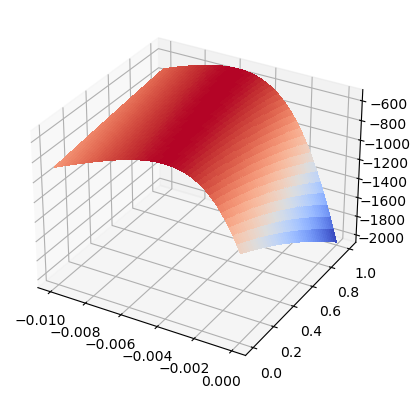

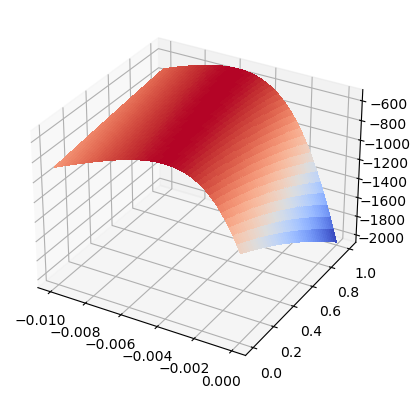

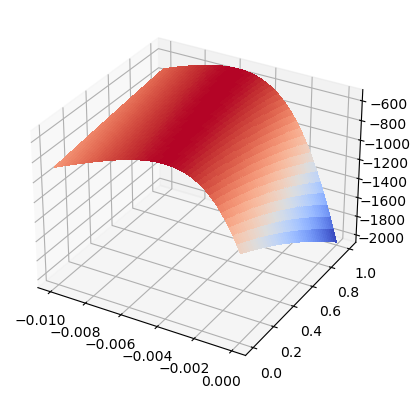

In [66]:
ngrid = 50
beta0 = np.linspace(0   ,1,ngrid) 
beta1 = np.linspace(-0.01,0,ngrid) 

# Create the surface for the ll-function.
ll=np.zeros((ngrid,ngrid))
for ii in range(ngrid):
  for jj in range(ngrid):
    beta      = [beta0[ii],beta1[jj]]
    ll[ii,jj] = loglike(beta,y,X)
  

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X = beta1
Y = beta0
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = -ll

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

In [67]:
from scipy.stats import chi2

logit_model   = sm.GLM(data['Default'],data[['FICO','c']], family=
                                                        sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Default   No. Observations:                 1699
Model:                            GLM   Df Residuals:                     1697
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -519.10
Date:                Sun, 23 Jan 2022   Deviance:                       1038.2
Time:                        00:56:39   Pearson chi2:                 1.72e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FICO          -0.0052      0.000    -10.651      0.0

In [161]:
# Compute predicted change in default probability as we move FICO from 800 to
# 500
logit_results.predict([500,1])-logit_results.predict([800,1])

array([0.0997374])

In [69]:
#  now let's to the analogue of the overall F test for the significance of the 
# regression -- this is now a Chi-squared test with degrees of freedom equal 
# to the number of regressors in the Logisic model
test_stat     = logit_results.null_deviance-logit_results.deviance
k             = 1
p_value_chisq = 1-chi2.cdf(test_stat,k)
test_stat
k
p_value_chisq

0.0

In [70]:
#convert df to numpy array
data['predicted'] = logit_results.predict(data[['FICO','c']].to_numpy())


prd_df = pd.DataFrame(logit_results.predict(data[['FICO','c']].to_numpy()),
                      columns=['Default'],index=data.index)


,Default
0,0.028019
1,0.039694
2,0.025700
3,0.110147
4,0.070767
...,...
1694,0.116442
1695,0.042790
1696,0.109127
1697,0.313565


In [71]:
data['type']='Default'
data['type'][data.Default==0]='No-Default'
data

<ipython-input-71-05e3e5d3fcff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'][data.Default==0]='No-Default'


,Default,FICO,c,predicted,type
0,0,815.0,1,0.028019,No-Default
1,0,746.0,1,0.039694,No-Default
2,0,832.0,1,0.025700,No-Default
3,0,536.0,1,0.110147,No-Default
4,0,629.0,1,0.070767,No-Default
...,...,...,...,...,...
1694,0,524.0,1,0.116442,No-Default
1695,0,731.0,1,0.042790,No-Default
1696,0,538.0,1,0.109127,No-Default
1697,0,286.0,1,0.313565,No-Default


In [72]:
prd_df['type'] = 'Predicted probabilities'
prd_df['FICO'] = data.FICO
data = data.append(prd_df)
data

,Default,FICO,c,predicted,type
0,0.000000,815.0,1.0,0.028019,No-Default
1,0.000000,746.0,1.0,0.039694,No-Default
2,0.000000,832.0,1.0,0.025700,No-Default
3,0.000000,536.0,1.0,0.110147,No-Default
4,0.000000,629.0,1.0,0.070767,No-Default
...,...,...,...,...,...
1694,0.116442,524.0,NaN,NaN,Predicted probabilities
1695,0.042790,731.0,NaN,NaN,Predicted probabilities
1696,0.109127,538.0,NaN,NaN,Predicted probabilities
1697,0.313565,286.0,NaN,NaN,Predicted probabilities


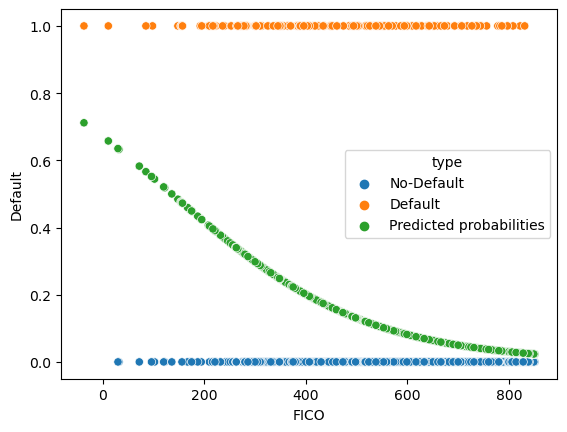

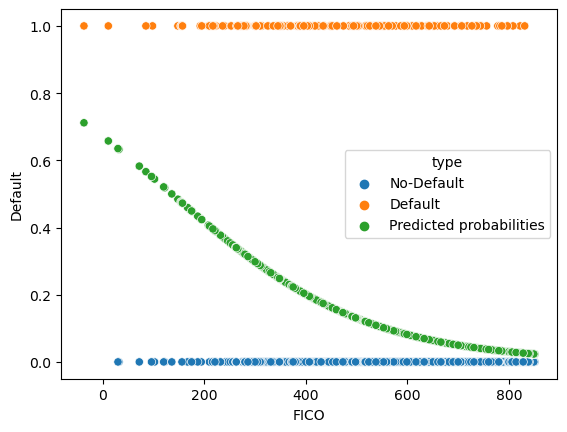

In [78]:
plt.figure()
ax = sns.scatterplot(data = data,
                    x     = 'FICO',
                    y     = 'Default',
                    hue   = 'type'
                   )
ax.set(xlabel  = 'FICO', 
       ylabel  = 'Default')
plt.show()

In [90]:
#Logistic Regression with more Complicated Example 
import statsmodels.api as sm
from patsy import dmatrices
#import feather
loans = pd.read_feather('/Users/johnkriston/Downloads/loans (1).feather')

In [98]:
y, Xf  = dmatrices('default ~ C(StatChkA) + Duration + C(CrdHist) + C(Purpose)\
                   + CrdAmt + C(Sav_Bnd)  + Emply     + C(InstallRate)\
                   + C(Pstatus) + C(OthrDebt) + Resid + C(Proprty) + Age \
                   + C(OthrInstall) + C(Housing)      + Ncredits + C(job)\
                   + Nsupport       + C(Telephone)    + Foreign', 
                   loans, return_type = 'dataframe')

In [99]:
logit_model_full = sm.GLM(y, Xf, family=sm.families.Binomial()).fit()
print(logit_model_full.summary())
phat_full = logit_model_full.predict(Xf)
phat_full

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      949
Model Family:                Binomial   Df Model:                           50
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -447.87
Date:                Mon, 24 Jan 2022   Deviance:                       895.75
Time:                        15:26:45   Pearson chi2:                     959.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

0      0.035017
1      0.626588
2      0.027599
3      0.248987
4      0.761278
         ...   
995    0.066087
996    0.487863
997    0.078393
998    0.646450
999    0.174620
Length: 1000, dtype: float64

In [100]:
#
# three types of variables
# Credit History
# loan characteristics
# demographics
#
# let's refit with only the factors that have significant coefficients 
#
y, X  = dmatrices('default ~ C(StatChkA) + Duration+ C(CrdHist) + C(Purpose)\
                             + CrdAmt + C(Sav_Bnd)+C(InstallRate) + C(Pstatus)\
                             + C(OthrDebt) + C(OthrInstall) + Foreign', 
                             loans, return_type = 'dataframe')
    
logit_model = sm.GLM(y,X, family=sm.families.Binomial()).fit()
print(logit_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      966
Model Family:                Binomial   Df Model:                           33
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -460.40
Date:                Mon, 24 Jan 2022   Deviance:                       920.81
Time:                        15:33:01   Pearson chi2:                     996.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

In [103]:
#Compute Analogue of Partial F Test

#17 variables thrown out (variables not factors)
delta_df = logit_model_full.df_model -logit_model.df_model
delta_df

17

In [105]:
#Fit is worse for simpler model by 25.06 "deviance" points 
delta_dev = logit_model.deviance - logit_model_full.deviance 
delta_dev

25.059807961647152

In [106]:
#P-value for test. Null: variables have zero coefficients (should be thrown out
#Restricted model not rejected at 5% level
p_value_chisq = 1-chi2.cdf(delta_dev,delta_df)
p_value_chisq

0.09337890681139305

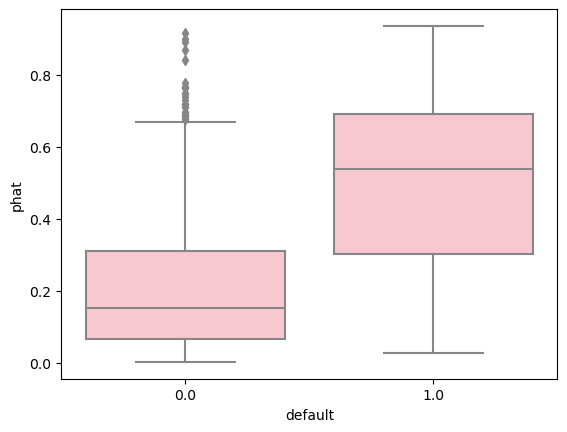

In [107]:
#Let's see how well model does by plotting the distribution of fitted probabilities by default 
loans['phat'] = logit_model.predict(X)
plt.figure()
ax = sns.boxplot(x='default', y='phat', data=loans,color='pink')
plt.show()

In [110]:
#Lift Table evaluates the ability of the model to predict default
loans['deciles'] = pd.qcut(loans['phat'], 10, labels=np.arange(1,11,1))
df = loans[['deciles', 'phat', 'default']]
lift = df.groupby('deciles')[['deciles', 'default']].mean()

#Compute mean response for each decile
lift['Lift Factor'] = lift['default']/np.mean(loans.default)
lift

#Looking for even increase in Lift from 1st through 10th decile and large
#values for highest deciles

,default,Lift Factor
deciles,,
1,0.03,0.100000
2,0.04,0.133333
3,0.11,0.366667
4,0.13,0.433333
5,0.19,0.633333
6,0.27,0.900000
7,0.39,1.300000
8,0.40,1.333333
9,0.67,2.233333


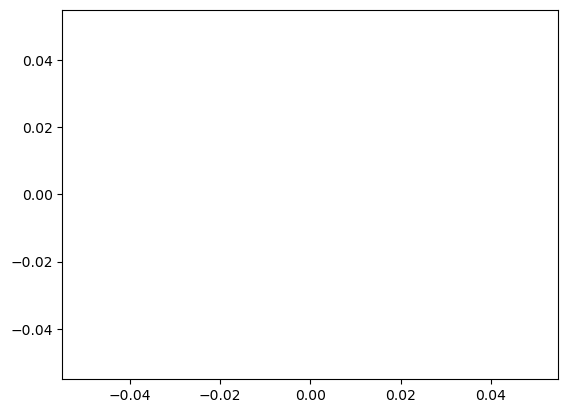

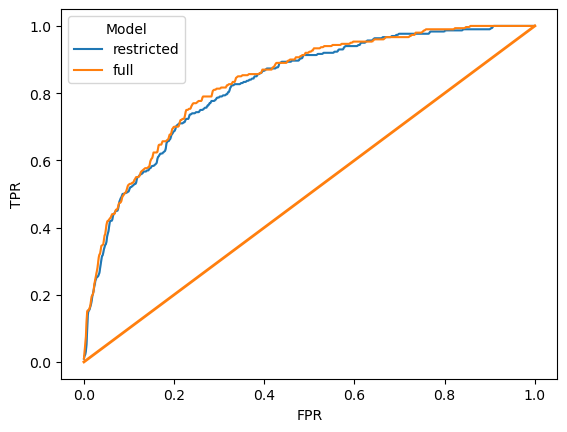

In [158]:
#AUC summarizes fit in one number
#Equivalent to the probability that the classifier will rank a randomly
#chosen positive instance higher than a randomly chosen negative instance

#Construct ROC curve from the restricted logistic regression model
def simple_roc(labels, scores):
    #reverses order or array elements along axis
    labels = np.flip([x for _, x in sorted(zip(scores,labels), reverse=False)])
    return pd.DataFrame({'TPR': np.cumsum(labels)/sum(labels),
                         'FPR': np.cumsum(~labels)/sum(~labels)})

glm_simple_roc = simple_roc(loans.default==1, loans.phat)
glm_simple_roc_full = simple_roc(loans.default==1,phat_full)
glm_simple_roc['Model'] = 'restricted' 
glm_simple_roc_full['Model'] = 'full'
New_ROC = glm_simple_roc.append(glm_simple_roc_full, ignore_index = True)
New_ROC

plt.figure()
ax = sns.lineplot(data=New_ROC, x="FPR", y="TPR", hue = 'Model')
plt.plot([0, 1], [0, 1], linewidth=2)
plt.show()